## Data Augmentation

In [204]:
# Image processing
import skimage
from skimage import data, io, transform
import cv2 as cv2
#ML
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix

#Other
import pandas as pd
import os
#Data Viz
from matplotlib import pyplot as plt
import seaborn as sns
from mlxtend.plotting import plot_confusion_matrix


### Example Images

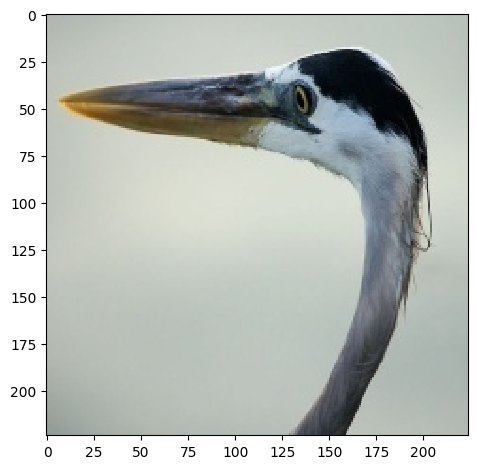

In [2]:
heron_example = 'archive\\train\BLUE HERON\\002.jpg'
io.imshow(heron_example)
plt.show()

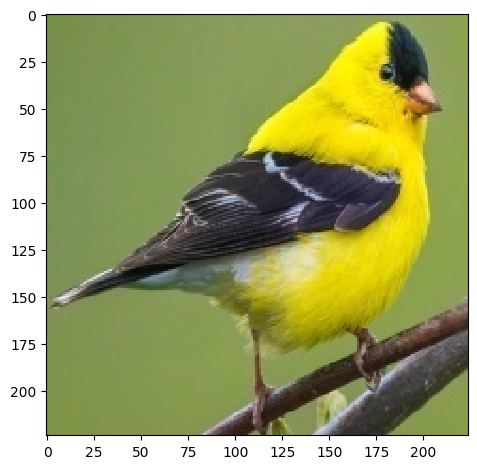

In [3]:
finch_example = 'archive\\train\AMERICAN GOLDFINCH\\001.jpg'
io.imshow(finch_example)
plt.show()

### Ways to Augment Image Data

### Rotations

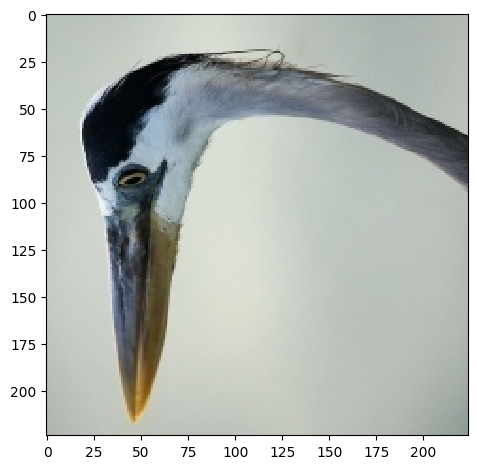

In [4]:
heron = io.imread(heron_example)
heron_rotate = transform.rotate(heron, 90)
io.imshow(heron_rotate)
plt.show()



### Adding Noise

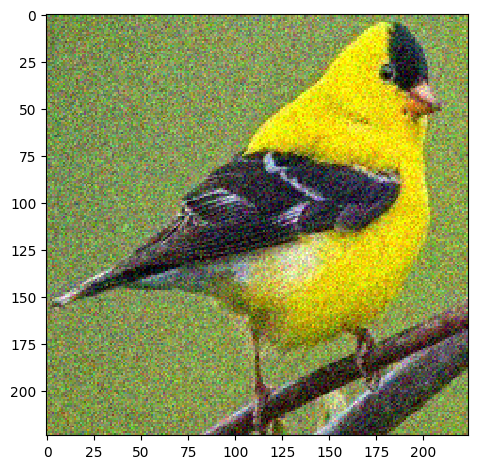

In [5]:
finch =io.imread(finch_example)
finch_guassian = skimage.util.random_noise(finch, mode='gaussian', seed=None, clip=True)
io.imshow(finch_guassian)

### Color Alterations

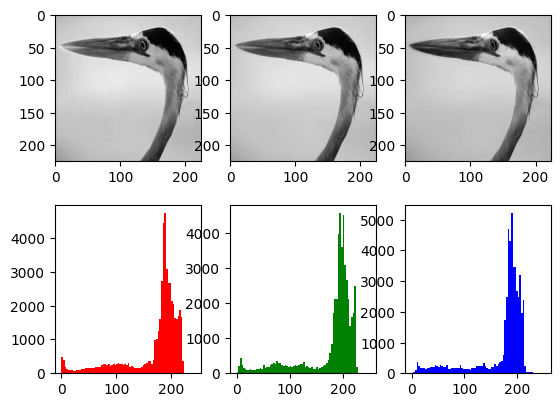

In [6]:
image_red, image_green, image_blue = heron[:,:,0], heron[:,:,1], heron[:,:,2]
fig, ax = plt.subplots(2,3)
ax[0,0].imshow(image_red, cmap='gray')
ax[0,1].imshow(image_green, cmap='gray')
ax[0,2].imshow(image_blue, cmap='gray')
 
bins = 80
ax[1,0].hist(image_red.flatten(), bins = bins, color='r')
ax[1,1].hist(image_green.flatten(), bins=bins, color='g')
ax[1,2].hist(image_blue.flatten(), bins=bins, color='b')
plt.show()


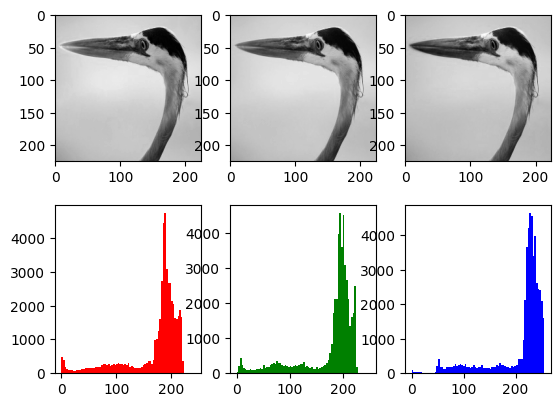

In [7]:
#Calulate mean
b_mean_shift = image_blue + 40

fig, ax = plt.subplots(2,3)
ax[0,0].imshow(image_red, cmap='gray')
ax[0,1].imshow(image_green, cmap='gray')
ax[0,2].imshow(image_blue, cmap='gray')
 
bins = 80
ax[1,0].hist(image_red.flatten(), bins = bins, color='r')
ax[1,1].hist(image_green.flatten(), bins=bins, color='g')
ax[1,2].hist(b_mean_shift.flatten(), bins=bins, color='b')
plt.show()



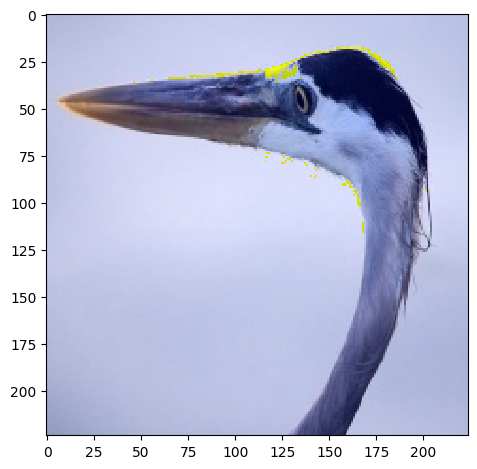

In [8]:
nb = np.dstack((image_red, image_green, b_mean_shift))
io.imshow(nb)
plt.show()

## Model Setup


#### Blue Heron n = 167 downsampled to n = 14

#### American Golden finch n = 134

### Model without augmentation

In [279]:
#Training Dataset
im_size =heron.shape[0]
batch_size = 40
train_ds = tf.keras.utils.image_dataset_from_directory(
  'archive/train',
  label_mode='categorical',
  labels = 'inferred',
  shuffle=True,
  seed=123,
  image_size=(im_size, im_size),
  batch_size=batch_size,
  validation_split = 0.2,
  subset='training')

valid_ds = tf.keras.utils.image_dataset_from_directory(
  'archive/train',
  label_mode='categorical',
  labels = 'inferred',
  shuffle=True,
  seed=123,
  image_size=(im_size, im_size),
  batch_size=batch_size,
  validation_split = 0.2,
  subset='validation')



test_ds = tf.keras.utils.image_dataset_from_directory('archive/test',
                                                                 batch_size=batch_size,
                                                                 image_size=(im_size, im_size),
                                                                  label_mode='categorical',
                                                                  labels = 'inferred',
                                                                  seed=123)

Found 147 files belonging to 2 classes.
Using 118 files for training.
Found 147 files belonging to 2 classes.
Using 29 files for validation.
Found 20 files belonging to 2 classes.


In [280]:
num_classes = 2
input_shape = (224, 224, 3)
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape = input_shape))
model.add(tf.keras.layers.Rescaling(1/255))
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(num_classes, activation='sigmoid'))

In [281]:
opt = tf.optimizers.Adam(0.0001)
model.compile(optimizer=opt,
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])
model.summary()

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_31 (Rescaling)    (None, 224, 224, 3)       0         
                                                                 
 conv2d_95 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_64 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_96 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_65 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_97 (Conv2D)          (None, 52, 52, 64)      

In [282]:
epochs = 10
history = model.fit(train_ds, validation_data=valid_ds, batch_size=batch_size, epochs=epochs, verbose=1)

Epoch 1/10
3/3 [==============================] - 4s 1s/step - loss: 0.4968 - accuracy: 0.9153 - val_loss: 0.6102 - val_accuracy: 0.8621
Epoch 2/10
3/3 [==============================] - 3s 1s/step - loss: 0.3389 - accuracy: 0.9153 - val_loss: 0.5336 - val_accuracy: 0.8621
Epoch 3/10
3/3 [==============================] - 3s 1s/step - loss: 0.3067 - accuracy: 0.9153 - val_loss: 0.4567 - val_accuracy: 0.8621
Epoch 4/10
3/3 [==============================] - 3s 1s/step - loss: 0.2948 - accuracy: 0.9153 - val_loss: 0.4220 - val_accuracy: 0.8621
Epoch 5/10
3/3 [==============================] - 3s 1s/step - loss: 0.2800 - accuracy: 0.9153 - val_loss: 0.4210 - val_accuracy: 0.8621
Epoch 6/10
3/3 [==============================] - 3s 1s/step - loss: 0.2573 - accuracy: 0.9153 - val_loss: 0.4096 - val_accuracy: 0.8621
Epoch 7/10
3/3 [==============================] - 3s 1s/step - loss: 0.2414 - accuracy: 0.9153 - val_loss: 0.3895 - val_accuracy: 0.8621
Epoch 8/10
3/3 [=========================

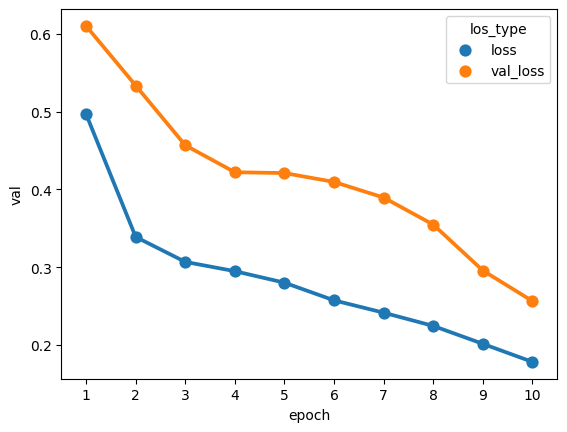

In [283]:
res = pd.DataFrame.from_dict(history.history)[['loss', 'val_loss']]
res['epoch'] = np.arange(1, res.shape[0]+1, dtype=int)
dfm = res.melt('epoch', var_name='los_type', value_name='val')
sns.pointplot(x="epoch", y="val", hue='los_type', data=dfm)
plt.show()

1/1 [==============================] - 0s 203ms/step


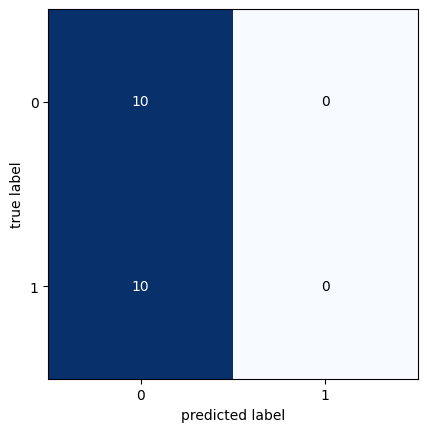

In [284]:
y_true = []
y_pred = []
for x,y in test_ds:
  y= tf.argmax(y,axis=1)
  y_true.append(y)
  y_pred.append(tf.argmax(model.predict(x),axis = 1))
  
y_pred = tf.concat(y_pred, axis=0)
y_true = tf.concat(y_true, axis=0)
mat = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(conf_mat = mat)
plt.show()

# With Augmentation

In [285]:
sdir= 'archive/train' # set this to the directory holding the images
ext='jpg' # specify the extension foor the aufmented images
prefix='aug' #set the prefix for the augmented images
batch_size=10 # set the batch size
passes=40  # set the number of time to cycle the generato
datagen = ImageDataGenerator( rotation_range=45, width_shift_range=0.2, height_shift_range=0.2, shear_range = 0.2,
                                zoom_range = 0.2,  horizontal_flip=True, fill_mode = 'nearest')
data=datagen.flow_from_directory(directory = sdir, batch_size = batch_size,  target_size = (256, 256),
                                 color_mode = 'rgb', shuffle=True)


for i in range (passes):
    images, labels=next(data)
    class_dict=data.class_indices
    new_dict={}
    # make a new dictionary with keys and values reversed
    for key, value in class_dict.items(): # dictionary is now {numeric class label: string of class_name}
        new_dict[value]=key    
    for j in range (len(labels)):                
        class_name = new_dict[np.argmax(labels[j])]         
        dir_path=os.path.join(sdir,class_name )         
        new_file=prefix + '-' +str(i*batch_size +j) + '.'  + ext       
        img_path=os.path.join(dir_path, new_file)        
        img=cv2.cvtColor(images[j], cv2.COLOR_BGR2RGB)
        cv2.imwrite(img_path, img)
print ('*** process complete') 

Found 147 images belonging to 2 classes.
*** process complete


In [286]:
#Training Dataset
im_size =heron.shape[0]
batch_size = 40
train_ds = tf.keras.utils.image_dataset_from_directory(
  'archive/train',
  label_mode='categorical',
  labels = 'inferred',
  shuffle=True,
  seed=123,
  image_size=(im_size, im_size),
  batch_size=batch_size,
  validation_split = 0.2,
  subset='training')

valid_ds = tf.keras.utils.image_dataset_from_directory(
  'archive/train',
  label_mode='categorical',
  labels = 'inferred',
  shuffle=True,
  seed=123,
  image_size=(im_size, im_size),
  batch_size=batch_size,
  validation_split = 0.2,
  subset='validation')



test_ds = tf.keras.utils.image_dataset_from_directory('archive/test',
                                                                 batch_size=batch_size,
                                                                 image_size=(im_size, im_size),
                                                                  label_mode='categorical',
                                                                  labels = 'inferred',
                                                                  seed=123)

Found 541 files belonging to 2 classes.
Using 433 files for training.
Found 541 files belonging to 2 classes.
Using 108 files for validation.
Found 20 files belonging to 2 classes.


In [287]:
num_classes = 2
input_shape = (224, 224, 3)
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape = input_shape))
model.add(tf.keras.layers.Rescaling(1/255))
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(num_classes, activation='sigmoid'))

opt = tf.optimizers.Adam(0.0001)
model.compile(optimizer=opt,
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])
epochs = 10
history = model.fit(train_ds, validation_data=valid_ds, batch_size=batch_size, epochs=epochs, verbose=1)

Epoch 1/10
11/11 [==============================] - 14s 1s/step - loss: 0.4146 - accuracy: 0.8776 - val_loss: 0.2635 - val_accuracy: 0.9167
Epoch 2/10
11/11 [==============================] - 12s 1s/step - loss: 0.2598 - accuracy: 0.8984 - val_loss: 0.2019 - val_accuracy: 0.9167
Epoch 3/10
11/11 [==============================] - 12s 1s/step - loss: 0.1853 - accuracy: 0.8984 - val_loss: 0.1796 - val_accuracy: 0.9167
Epoch 4/10
11/11 [==============================] - 12s 1s/step - loss: 0.1525 - accuracy: 0.9099 - val_loss: 0.1724 - val_accuracy: 0.9537
Epoch 5/10
11/11 [==============================] - 12s 1s/step - loss: 0.1392 - accuracy: 0.9307 - val_loss: 0.1623 - val_accuracy: 0.9352
Epoch 6/10
11/11 [==============================] - 12s 1s/step - loss: 0.1190 - accuracy: 0.9561 - val_loss: 0.1360 - val_accuracy: 0.9537
Epoch 7/10
11/11 [==============================] - 12s 1s/step - loss: 0.0911 - accuracy: 0.9723 - val_loss: 0.1208 - val_accuracy: 0.9444
Epoch 8/10
11/11 [==

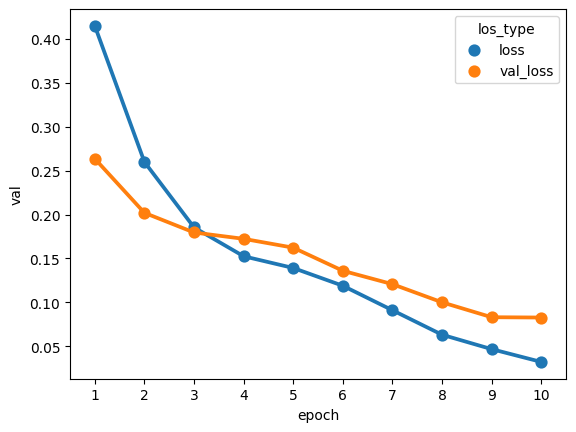

In [289]:
res = pd.DataFrame.from_dict(history.history)[['loss', 'val_loss']]
res['epoch'] = np.arange(1, res.shape[0]+1, dtype=int)
dfm = res.melt('epoch', var_name='los_type', value_name='val')
sns.pointplot(x="epoch", y="val", hue='los_type', data=dfm)
plt.show()

1/1 [==============================] - 0s 207ms/step


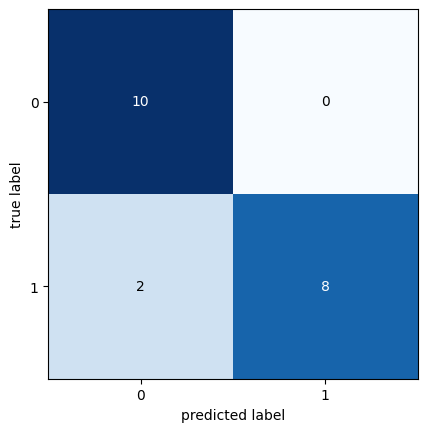

In [288]:
y_true = []
y_pred = []
for x,y in test_ds:
  y= tf.argmax(y,axis=1)
  y_true.append(y)
  y_pred.append(tf.argmax(model.predict(x),axis = 1))
  
y_pred = tf.concat(y_pred, axis=0)
y_true = tf.concat(y_true, axis=0)
mat = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(conf_mat = mat)
plt.show()